In [1]:
import os, math, json, random
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms as T
from torchvision import models as tvm
from torchvision.models import ResNet18_Weights

from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm

# Metrics
from torchmetrics.classification import MulticlassAccuracy, MulticlassAUROC

In [2]:
DATA_ROOT = Path("../../data/processed/classification/leukemia_classification/")

TRAIN_DIR = DATA_ROOT / "train"
VAL_DIR   = DATA_ROOT / "validation"
TEST_DIR  = DATA_ROOT / "test"


In [3]:

print("Train path:", TRAIN_DIR)
print("Val path:  ", VAL_DIR)
print("Test path: ", TEST_DIR)

Train path: ..\..\data\processed\classification\leukemia_classification\train
Val path:   ..\..\data\processed\classification\leukemia_classification\validation
Test path:  ..\..\data\processed\classification\leukemia_classification\test


In [4]:
assert TRAIN_DIR.exists(), f"Train dir not found: {TRAIN_DIR}"
assert VAL_DIR.exists(),   f"Validation dir not found: {VAL_DIR}"
assert TEST_DIR.exists(),  f"Test dir not found: {TEST_DIR}"

In [7]:
from torchvision import transforms as T

IMG_SIZE = 224  # ResNet-18 input size

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_tfms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.5),
    T.RandomRotation(degrees=15),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    T.ToTensor(),
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

val_tfms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])


In [8]:
from torchvision.datasets import ImageFolder

In [9]:

train_ds = ImageFolder(TRAIN_DIR, transform=train_tfms)
val_ds   = ImageFolder(VAL_DIR,   transform=val_tfms)
test_ds  = ImageFolder(TEST_DIR,  transform=val_tfms)

class_names = train_ds.classes
num_classes = len(class_names)

print("Classes:", class_names)
print("Train size:", len(train_ds))
print("Val size:", len(val_ds))
print("Test size:", len(test_ds))


Classes: ['fold_0', 'fold_1', 'fold_2']
Train size: 8885
Val size: 1776
Test size: 1867


In [10]:
from torch.utils.data import ConcatDataset

# Load each fold separately
train_fold0 = ImageFolder(TRAIN_DIR / "fold_0", transform=train_tfms)
train_fold1 = ImageFolder(TRAIN_DIR / "fold_1", transform=train_tfms)
train_fold2 = ImageFolder(TRAIN_DIR / "fold_2", transform=train_tfms)

# Merge into one training dataset
train_ds = ConcatDataset([train_fold0, train_fold1, train_fold2])

# Validation and test stay the same
val_ds  = ImageFolder(VAL_DIR,  transform=val_tfms)
test_ds = ImageFolder(TEST_DIR, transform=val_tfms)

# Classes (same for all folds)
class_names = train_fold0.classes
num_classes = len(class_names)

print("Classes:", class_names)
print("Train size:", len(train_ds))
print("Val size:", len(val_ds))
print("Test size:", len(test_ds))


Classes: ['all', 'hem']
Train size: 8885
Val size: 1776
Test size: 1867


Data loaders

In [12]:
from torch.utils.data import DataLoader

def seed_worker(worker_id):
    worker_seed = (torch.initial_seed() + worker_id) % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(42)

batch_size = 32
num_workers = 0
pin = torch.cuda.is_available()

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                          num_workers=num_workers, pin_memory=pin,
                          worker_init_fn=seed_worker, generator=g)

val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False,
                        num_workers=num_workers, pin_memory=pin,
                        worker_init_fn=seed_worker, generator=g)

test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False,
                         num_workers=num_workers, pin_memory=pin,
                         worker_init_fn=seed_worker, generator=g)

print("Steps per epoch:", len(train_loader), len(val_loader), len(test_loader))

# Smoke test: check a batch
xb, yb = next(iter(train_loader))
print("First batch:", xb.shape, yb.shape)


Steps per epoch: 278 56 59
First batch: torch.Size([32, 3, 224, 224]) torch.Size([32])


In [13]:
from torchvision import models as tvm
from torchvision.models import ResNet18_Weights
from collections import Counter

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [18]:
cnt = Counter()
for d in train_ds.datasets:       # loop over each fold (ImageFolder)
    cnt.update([y for _, y in d.samples])

print("Train class counts:", cnt)

Train class counts: Counter({0: 6044, 1: 2841})


In [19]:
freqs = np.array([cnt.get(i, 0) for i in range(num_classes)], dtype=float)
weights = (1.0 / (freqs + 1e-9))
weights = weights / weights.sum() * num_classes
class_weights = torch.tensor(weights, dtype=torch.float32, device=device)

print("Class weights:", class_weights)

Class weights: tensor([0.6395, 1.3605], device='cuda:0')


In [20]:
# --- Define model ---
model = tvm.resnet18(weights=ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, num_classes)  # replace head
model = model.to(device)

In [26]:
# --- Loss, Optimizer, Scheduler ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

epochs = 20
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

In [27]:
from torch.cuda.amp import autocast, GradScaler

scaler = GradScaler(enabled=torch.cuda.is_available())


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_5148\2695130681.py:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=torch.cuda.is_available())


In [31]:
def run_epoch(loader, train=True):
    model.train(train)
    loss_sum = 0.0
    logits_all, targets_all = [], []

    for x, yb in tqdm(loader, leave=False):
        x, yb = x.to(device, non_blocking=True), yb.to(device, non_blocking=True)

        if train:
            optimizer.zero_grad(set_to_none=True)
            with torch.amp.autocast("cuda", enabled=torch.cuda.is_available()):
                logits = model(x)
                logits = torch.nan_to_num(logits, nan=0.0, posinf=1e4, neginf=-1e4)
                loss = criterion(logits, yb)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            with torch.no_grad(), torch.amp.autocast("cuda", enabled=torch.cuda.is_available()):
                logits = model(x)
                logits = torch.nan_to_num(logits, nan=0.0, posinf=1e4, neginf=-1e4)
                loss = criterion(logits, yb)

        loss_sum += loss.item() * x.size(0)
        logits_all.append(logits.detach().float().cpu())
        targets_all.append(yb.detach().long().cpu())

    # Aggregate
    loss_epoch = loss_sum / len(loader.dataset)
    logits_all = torch.cat(logits_all)
    targets_all = torch.cat(targets_all)

    auroc = MulticlassAUROC(num_classes=num_classes, average="macro")(
        logits_all.softmax(1), targets_all
    ).item()
    acc = MulticlassAccuracy(num_classes=num_classes, average="macro")(
        logits_all.argmax(1), targets_all
    ).item()

    return loss_epoch, acc, auroc

In [32]:
import json

CKPT_DIR = Path("checkpoints")
CKPT_DIR.mkdir(exist_ok=True)

def fit(epochs=20, ckpt_name="leukemia_resnet18.pt"):
    best = -math.inf
    hist = []

    for ep in range(1, epochs + 1):
        tr_loss, tr_acc, tr_auc = run_epoch(train_loader, True)
        va_loss, va_acc, va_auc = run_epoch(val_loader, False)

        scheduler.step()

        hist.append({
            "epoch": ep,
            "train_loss": tr_loss, "train_acc": tr_acc, "train_auroc": tr_auc,
            "val_loss": va_loss, "val_acc": va_acc, "val_auroc": va_auc,
            "lr": scheduler.get_last_lr()[0]
        })

        print(f"[{ep:03d}] "
              f"train: loss {tr_loss:.4f} acc {tr_acc:.3f} auroc {tr_auc:.3f} | "
              f"val: loss {va_loss:.4f} acc {va_acc:.3f} auroc {va_auc:.3f}")

        if va_auc > best:
            best = va_auc
            torch.save({
                "state_dict": model.state_dict(),
                "class_names": class_names,
                "num_classes": num_classes,
            }, CKPT_DIR / ckpt_name)

    with open("training_history.json", "w") as f:
        json.dump(hist, f, indent=2)

    print("Best val AUROC:", best)
    return hist


In [34]:
print("Val classes:", val_ds.classes)

Val classes: ['all', 'hem']


In [35]:
from collections import Counter
val_counts = Counter([y for _, y in val_ds.samples])
print("Val class counts:", val_counts)


Val class counts: Counter({0: 1228, 1: 548})


In [36]:
print("Train classes:", train_fold0.classes)
print("Val classes:", val_ds.classes)
print("Test classes:", test_ds.classes)

Train classes: ['all', 'hem']
Val classes: ['all', 'hem']
Test classes: ['all', 'hem']


In [37]:
history = fit(epochs=epochs)

[001] train: loss 0.3113 acc 0.832 auroc 0.916 | val: loss 0.6934 acc 0.500 auroc 0.500


[002] train: loss 0.2992 acc 0.841 auroc 0.922 | val: loss 0.6934 acc 0.500 auroc 0.500


[003] train: loss 0.2820 acc 0.854 auroc 0.932 | val: loss 0.6934 acc 0.500 auroc 0.500


[004] train: loss 0.2702 acc 0.860 auroc 0.934 | val: loss 0.6934 acc 0.500 auroc 0.500


[005] train: loss 0.2570 acc 0.868 auroc 0.942 | val: loss 0.6934 acc 0.500 auroc 0.500


[006] train: loss 0.2579 acc 0.869 auroc 0.941 | val: loss 0.6934 acc 0.500 auroc 0.500


[007] train: loss 0.2413 acc 0.879 auroc 0.947 | val: loss 0.6934 acc 0.500 auroc 0.500


[008] train: loss 0.2351 acc 0.883 auroc 0.952 | val: loss 0.6934 acc 0.500 auroc 0.500


[009] train: loss 0.2368 acc 0.879 auroc 0.949 | val: loss 0.6934 acc 0.500 auroc 0.500


[010] train: loss 0.2223 acc 0.887 auroc 0.956 | val: loss 0.6934 acc 0.500 auroc 0.500


[011] train: loss 0.2175 acc 0.892 auroc 0.958 | val: loss 0.6934 acc 0.500 auroc 0.500


[012] train: loss 0.2133 acc 0.894 auroc 0.960 | val: loss 0.6934 acc 0.500 auroc 0.500


[013] train: loss 0.2037 acc 0.900 auroc 0.962 | val: loss 0.6934 acc 0.500 auroc 0.500


[014] train: loss 0.1951 acc 0.900 auroc 0.966 | val: loss 0.6934 acc 0.500 auroc 0.500


[015] train: loss 0.1925 acc 0.902 auroc 0.968 | val: loss 0.6934 acc 0.500 auroc 0.500


[016] train: loss 0.1835 acc 0.908 auroc 0.971 | val: loss 0.6934 acc 0.500 auroc 0.500


[017] train: loss 0.1841 acc 0.911 auroc 0.970 | val: loss 0.6934 acc 0.500 auroc 0.500


[018] train: loss 0.1853 acc 0.908 auroc 0.969 | val: loss 0.6934 acc 0.500 auroc 0.500


[019] train: loss 0.1851 acc 0.909 auroc 0.970 | val: loss 0.6934 acc 0.500 auroc 0.500


[020] train: loss 0.1889 acc 0.911 auroc 0.971 | val: loss 0.6934 acc 0.500 auroc 0.500
Best val AUROC: 0.5


In [39]:
from pathlib import Path
import torch

CKPT_DIR = Path(r"C:\Users\Lenovo\Desktop\Exploration-of-ViT-and-CNN-for-Medical-Image-Processing\checkpoints\classification")
CKPT_DIR.mkdir(parents=True, exist_ok=True)

ckpt_path = CKPT_DIR / "cls_leukemia_resnet18.pt"

# Save current model
torch.save({
    "state_dict": model.state_dict(),
    "class_names": class_names,
    "num_classes": num_classes,
}, ckpt_path)

print("Checkpoint saved →", ckpt_path)


Checkpoint saved → C:\Users\Lenovo\Desktop\Exploration-of-ViT-and-CNN-for-Medical-Image-Processing\checkpoints\classification\cls_leukemia_resnet18.pt


In [ ]:
import json, torch, numpy as np, seaborn as sns, matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from torchmetrics.classification import MulticlassAUROC
from tqdm.auto import tqdm
from pathlib import Path

ckpt_path = Path(r"C:\Users\Lenovo\Desktop\Exploration-of-ViT-and-CNN-for-Medical-Image-Processing\checkpoints\classification\cls_leukemia_resnet18.pt")
state = torch.load(ckpt_path, map_location=device)
model.load_state_dict(state["state_dict"]); model.eval()
print("Loaded checkpoint →", ckpt_path)

logits_list, targets_list = [], []
with torch.no_grad():
    for x, y in tqdm(test_loader, leave=False):
        logits_list.append(model(x.to(device)).cpu())
        targets_list.append(y.cpu())

logits = torch.cat(logits_list)
targets = torch.cat(targets_list)

probs = logits.softmax(1).numpy()
preds = probs.argmax(1)
targets_np = targets.numpy()

test_auroc = MulticlassAUROC(num_classes=num_classes, average="macro")(
    torch.tensor(probs), torch.tensor(targets_np)
).item()
test_acc = float((preds == targets_np).mean())

report = classification_report(
    targets_np, preds, target_names=class_names, output_dict=True
)

MET_DIR = Path(r"C:\Users\Lenovo\Desktop\Exploration-of-ViT-and-CNN-for-Medical-Image-Processing\results\metrics")
MET_DIR.mkdir(parents=True, exist_ok=True)
out_json = MET_DIR / "cls_leukemia_resnet18_test.json"

with open(out_json, "w") as f:
    json.dump({
        "dataset": "leukemia",
        "model": "resnet18",
        "num_classes": num_classes,
        "test_macro_auroc": test_auroc,
        "test_accuracy": test_acc,
        "classification_report": report
    }, f, indent=2)

print("Saved →", out_json)

cm = confusion_matrix(targets_np, preds)
FIG_DIR = Path(r"C:\Users\Lenovo\Desktop\Exploration-of-ViT-and-CNN-for-Medical-Image-Processing\results\figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Leukemia • ResNet-18 Confusion Matrix")
plt.tight_layout()

fig_path = FIG_DIR / "cls_leukemia_resnet18_confusion_matrix.png"
plt.savefig(fig_path, dpi=150); plt.show()
print("Saved →", fig_path)


📈 Training Curves

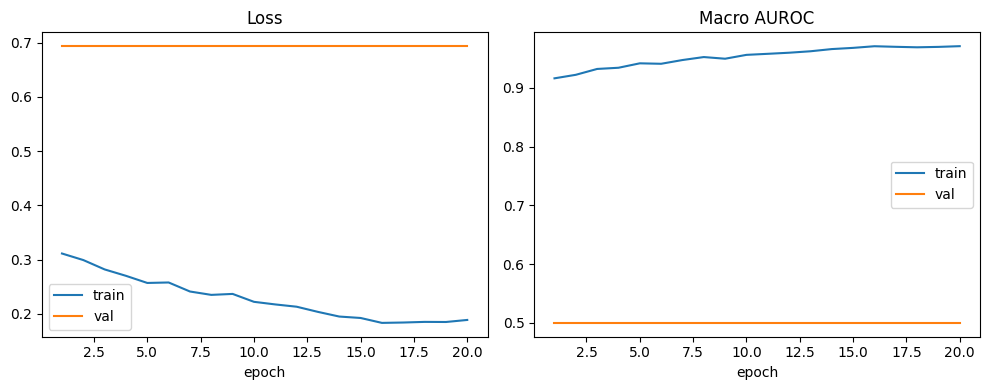

In [41]:
hist = json.loads(Path("training_history.json").read_text())

epochs = [h["epoch"] for h in hist]
tr_loss = [h["train_loss"] for h in hist]; va_loss = [h["val_loss"] for h in hist]
tr_auc  = [h["train_auroc"] for h in hist]; va_auc  = [h["val_auroc"] for h in hist]

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(epochs, tr_loss, label="train"); plt.plot(epochs, va_loss, label="val")
plt.title("Loss"); plt.xlabel("epoch"); plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, tr_auc, label="train"); plt.plot(epochs, va_auc, label="val")
plt.title("Macro AUROC"); plt.xlabel("epoch"); plt.legend()

plt.tight_layout(); plt.show()


🚀 Model Export (ONNX + TorchScript)

In [42]:
# === Export to ONNX & TorchScript ===
onnx_out = Path(r"C:\Users\Lenovo\Desktop\Exploration-of-ViT-and-CNN-for-Medical-Image-Processing\exports\onnx\leukemia_resnet18.onnx")
ts_out   = Path(r"C:\Users\Lenovo\Desktop\Exploration-of-ViT-and-CNN-for-Medical-Image-Processing\exports\torchscript\leukemia_resnet18.pt")

onnx_out.parent.mkdir(parents=True, exist_ok=True)
ts_out.parent.mkdir(parents=True, exist_ok=True)

dummy = torch.randn(1, 3, 224, 224, device=device)
model.eval()

# ONNX
torch.onnx.export(model, dummy, onnx_out.as_posix(),
                  input_names=["input"], output_names=["logits"],
                  opset_version=17,
                  dynamic_axes={"input": {0:"batch"}, "logits": {0:"batch"}})
print("ONNX saved →", onnx_out)

# TorchScript
traced = torch.jit.trace(model, dummy)
traced.save(ts_out.as_posix())
print("TorchScript saved →", ts_out)


ONNX saved → C:\Users\Lenovo\Desktop\Exploration-of-ViT-and-CNN-for-Medical-Image-Processing\exports\onnx\leukemia_resnet18.onnx
TorchScript saved → C:\Users\Lenovo\Desktop\Exploration-of-ViT-and-CNN-for-Medical-Image-Processing\exports\torchscript\leukemia_resnet18.pt


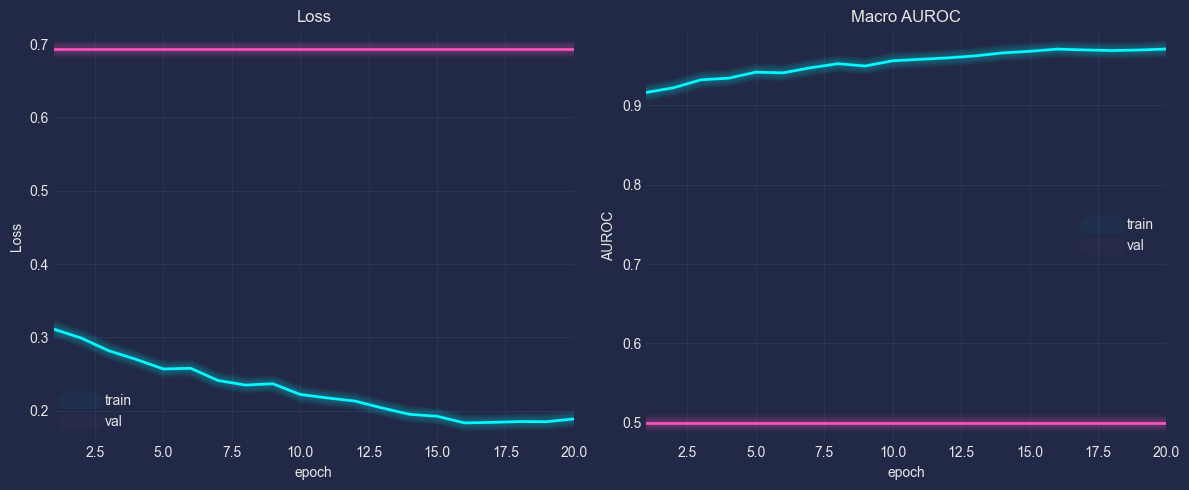

In [51]:
import json
import matplotlib.pyplot as plt
import mplcyberpunk
from pathlib import Path

plt.style.use("cyberpunk")

# Load history
REPO_ROOT = Path(r"C:\Users\Lenovo\Desktop\Exploration-of-ViT-and-CNN-for-Medical-Image-Processing")
hist_path = REPO_ROOT / "results" / "metrics" / "leukemia_resnet18_history.json"
hist = json.loads(Path(hist_path).read_text())

epochs  = [h["epoch"] for h in hist]
tr_loss = [h["train_loss"] for h in hist]; va_loss = [h["val_loss"] for h in hist]
tr_auc  = [h["train_auroc"] for h in hist]; va_auc  = [h["val_auroc"] for h in hist]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# --- Loss ---
ax1.plot(epochs, tr_loss, label="train", linewidth=2)
ax1.plot(epochs, va_loss, label="val", linewidth=2)
mplcyberpunk.make_lines_glow(ax=ax1)
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(dict(zip(labels, handles)).values(), dict(zip(labels, handles)).keys())
ax1.set_title("Loss")
ax1.set_xlabel("epoch"); ax1.set_ylabel("Loss")
ax1.margins(x=0)

# --- AUROC ---
ax2.plot(epochs, tr_auc, label="train", linewidth=2)
ax2.plot(epochs, va_auc, label="val", linewidth=2)
mplcyberpunk.make_lines_glow(ax=ax2)
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(dict(zip(labels, handles)).values(), dict(zip(labels, handles)).keys())
ax2.set_title("Macro AUROC")
ax2.set_xlabel("epoch"); ax2.set_ylabel("AUROC")
ax2.margins(x=0)

plt.tight_layout()
plt.show()
